In [1]:
import sys, os, importlib, math, multiprocessing
import rasterio, geojson

import pandas as pd
import geopandas as gpd
import numpy as np

from h3 import h3
from tqdm import tqdm
from shapely.geometry import Polygon

sys.path.insert(0, "/home/wb411133/Code/gostrocks/src")
import GOSTRocks.rasterMisc as rMisc
import GOSTRocks.ntlMisc as ntl
import GOSTRocks.mapMisc as mapMisc
from GOSTRocks.misc import tPrint

sys.path.append("../src")
import h3_helper
import country_zonal

%load_ext autoreload
%autoreload 2

/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [25]:
h3_level = 5

admin_bounds = "/home/public/Data/GLOBAL/ADMIN/ADMIN2/HighRes_20230328/shp/WB_GAD_ADM2.shp"
fews_folder = f"/home/wb411133/projects/Space2Stats/FEWSNET"
out_folder = os.path.join(fews_folder, "ADM_SUMMARY")
if not os.path.exists(out_folder):
    os.makedirs(out_folder)
    
ndvi_file = os.path.join(fews_folder, 'h3_fews.csv')
out_summary_file = os.path.join(out_folder, "fews_summary.geojson")

In [26]:
in_ndvi = pd.read_csv(ndvi_file)
in_ndvi.head()

,hex_id,CS,HA0,geometry,ym,inter_area
0,85208003fffffff,1.0,NaN,"POLYGON ((7890617.841647229 4556886.523086012,...",2009-07,4.753778e+08
1,85208003fffffff,2.0,NaN,"POLYGON ((7890617.841647229 4556886.523086012,...",2009-10,4.753778e+08
2,85208003fffffff,2.0,NaN,"POLYGON ((7890617.841647229 4556886.523086012,...",2010-01,4.753778e+08
3,85208003fffffff,1.0,NaN,"POLYGON ((7890617.841647229 4556886.523086012,...",2010-04,4.753778e+08
4,85208003fffffff,2.0,NaN,"POLYGON ((7890617.841647229 4556886.523086012,...",2010-07,4.753778e+08


In [28]:
inN = pd.pivot(in_ndvi, index='hex_id', columns='ym', values='CS')

In [40]:
sel_iso3 = ['KEN','SSD']
all_a = gpd.read_file(admin_bounds)
all_a['gID'] = list(all_a.index)
selA = all_a.loc[all_a['WB_A3'].isin(sel_iso3)]
selA.head()

,ISO_A3,ISO_A2,WB_A3,HASC_0,HASC_1,HASC_2,GAUL_0,GAUL_1,GAUL_2,WB_REGION,...,NAM_2,NAM_2_GAUL,NAM_2_STAT,NAM_2_SRCE,NAM_2_NTVE,NAM_2_WIKI,Shape_Leng,Shape_Area,geometry,gID
36683,KEN,KE,KEN,KE,None,None,133,0,0,AFR,...,Ainabkoi,None,None,None,None,None,1.746986,0.040829,"POLYGON ((35.46330 0.50720, 35.46319 0.50205, ...",36683
36684,KEN,KE,KEN,KE,None,None,133,0,0,AFR,...,Ainamoi,None,None,None,None,None,0.917307,0.019957,"POLYGON ((35.32495 -0.25056, 35.32775 -0.25211...",36684
36685,KEN,KE,KEN,KE,None,None,133,0,0,AFR,...,Aldai,None,None,None,None,None,1.402637,0.038000,"POLYGON ((35.13034 0.13630, 35.12981 0.13534, ...",36685
36686,KEN,KE,KEN,KE,None,None,133,0,0,AFR,...,Alego Usonga,None,None,None,None,None,1.081354,0.049357,"POLYGON ((34.21848 0.16479, 34.21617 0.16180, ...",36686
36687,KEN,KE,KEN,KE,None,None,133,0,0,AFR,...,Awendo,None,None,None,None,None,0.743915,0.021365,"POLYGON ((34.62157 -0.98540, 34.61197 -0.99600...",36687


In [ ]:
zonal_res = country_zonal.connect_polygons_h3_stats(all_a, inN, 5, 'gID', fractional_res=True, 
                                                    zonal_res_id='hex_id', default_sum='MEAN')

In [ ]:
zonal_res.head()

In [32]:
merged_res = selA.merge(zonal_res, left_on='gID', right_on='id')
merged_res.to_file(out_summary_file, driver="GeoJSON")

<module 'matplotlib.pyplot' from '/home/wb411133/.conda/envs/ee/lib/python3.9/site-packages/matplotlib/pyplot.py'>

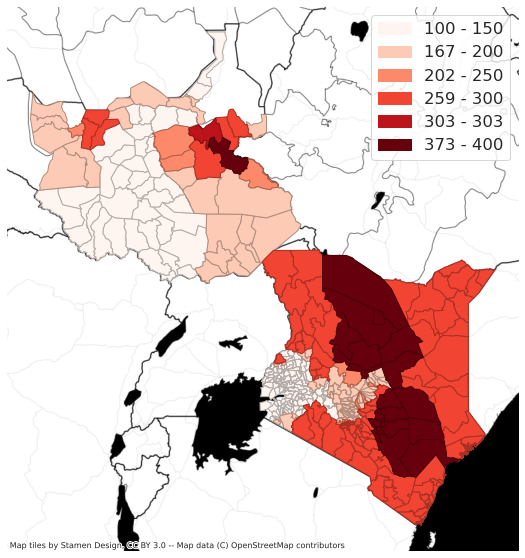

In [34]:
merged_res['map_col'] = merged_res['2009-07'] * 100
mapMisc.static_map_vector(merged_res, 'map_col')

# DEBUGGING

In [ ]:
inN.head()

In [ ]:
row = selA.iloc[0]
xx = country_zonal.calculate_value(row['geometry'], inN, 5, row['gID'], fractional_res=True, zonal_res_id='hex_id', default_sum='MEAN')

In [ ]:
xx